# Data preparation

In [1]:
data_map = {'defect_eclipse_2_0' : "https://automlws7601807515.blob.core.windows.net/azureml-blobstore-8faf4f37-1f8f-49d3-8a7a-42d7e987d8b3/defect_eclipse_2_0.csv",
           'defect_camel_1_2':'https://automlws7601807515.blob.core.windows.net/azureml-blobstore-8faf4f37-1f8f-49d3-8a7a-42d7e987d8b3/defect_camel_1_2.csv',
           'defect_eclipse_3_0':'https://automlws7601807515.blob.core.windows.net/azureml-blobstore-8faf4f37-1f8f-49d3-8a7a-42d7e987d8b3/defect_eclipse_3_0.csv',
           'defect_prop_2':'https://automlws7601807515.blob.core.windows.net/azureml-blobstore-8faf4f37-1f8f-49d3-8a7a-42d7e987d8b3/defect_prop_2.csv',
           'defect_xalan_2_6':'https://automlws7601807515.blob.core.windows.net/azureml-blobstore-8faf4f37-1f8f-49d3-8a7a-42d7e987d8b3/defect_xalan_2_6.csv'}

In [2]:
import os
#dataset_name = "defect_camel_1_2"
dataset_name = "defect_eclipse_2_0"
#dataset_name = "defect_eclipse_3_0"
#dataset_name = "defect_prop_2"
#dataset_name = "defect_xalan_2_6"
dataset_file_name = dataset_name+'.csv'
dataset_path_name = os.path.join(os.getcwd(),dataset_name+'.csv' )

In [3]:
import pandas as pd
df = pd.read_csv(dataset_file_name)
x_df = df.drop(columns =['target'])
y_df = df[['target']]
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=42)
# flatten y_train to 1d array
#y_train.values.flatten()# flatten y_train to 1d array


# Setting 

In [4]:
import azureml.core
import logging

print("SDK version:", azureml.core.VERSION)

from azureml.telemetry import set_diagnostics_collection
set_diagnostics_collection(send_diagnostics=True)

SDK version: 1.0.45
Turning diagnostics collection on. 


In [5]:
import os

subscription_id = os.getenv("SUBSCRIPTION_ID", default="46fcf3a4-0d3b-478f-ac67-9cd2d0a69056")
resource_group = os.getenv("RESOURCE_GROUP", default="automl_group")
workspace_name = os.getenv("WORKSPACE_NAME", default="automl_ws")
workspace_region = os.getenv("WORKSPACE_REGION", default="eastus2")


In [6]:
from azureml.core import Workspace
from azureml.core.authentication import InteractiveLoginAuthentication

try:
    interactive_auth = InteractiveLoginAuthentication(tenant_id="104d804d-6298-4cb6-8de3-22ddc7db5aa0")
    ws = Workspace(subscription_id = subscription_id, 
               resource_group = resource_group, 
               workspace_name = workspace_name,
               auth=interactive_auth)    # write the details of the workspace to a configuration file to the notebook library
    ws.write_config()
    print("Workspace configuration succeeded.")
except:
    print("Workspace not accessible.")

Workspace configuration succeeded.


In [7]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
cpu_cluster_name = "cpucluster1"

# Verify that cluster does not exist already
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print("Found existing cpucluster")
except ComputeTargetException:
    print("Creating new cpucluster")
    
    # Specify the configuration for the new cluster
    compute_config = AmlCompute.provisioning_configuration(vm_size="STANDARD_D2_V2",
                                                           min_nodes=0,
                                                           max_nodes=4)

    # Create the cluster with the specified name and configuration
    cpu_cluster = ComputeTarget.create(ws, cpu_cluster_name, compute_config)
    
    # Wait for the cluster to complete, show the output log
    cpu_cluster.wait_for_completion(show_output=True)

Found existing cpucluster


# Model setting

In [8]:
# should be enum
candidate_algorithem = ['xgboost','randomforest','logistic_regression','fft']

chosen_algo = 'xgboost'

In [9]:

estimator_map  = {'xgboost':'xgb_train.py',
                  'randomforest':'rf_train.py',
                  'logistic_regression':'lr_train.py',
                  'fft':'fft_train.py'    
                 }

# Estimator

In [10]:
# from azureml.train.sklearn import SKLearn
# = SKLearn(
from azureml.train.estimator import Estimator
script_params = {
        "--split-random-seeds":42, # seed for splitting data
        "--data-download-url" : data_map[dataset_name], # data download url
        "--dataset-name" :dataset_name,
        '--output_dir': './outputs'
}

estimator = Estimator(source_directory='./estimator',
                   script_params=script_params,
                   compute_target=cpu_cluster,
                   entry_script=estimator_map[chosen_algo],
                   conda_packages=['scikit-learn','pandas','py-xgboost=0.80']
                    )

# Hyperparameter space

In [11]:
from azureml.train.hyperdrive import RandomParameterSampling
from azureml.train.hyperdrive import choice, uniform

# xgboost
xgb_param_sampling  = RandomParameterSampling( 
    {
        "max-depth":choice(range(3,10)),
        "eta":1,
        "silent":1,
        'learning_rate': uniform(0.01,0.1),
        'subsample': uniform(0.8,1),
        'colsample_bytree': uniform(0.3,1),
        'gamma': choice(0,1,5)
    }
)

# randomforest
rf_param_sampling  = RandomParameterSampling( 
    {
        "mtry":choice(range(3,10))
    }
)

# logistic regression
lr_param_sampling  = RandomParameterSampling( 
    {
        "alpha":choice(range(3,10))
    }
)

# fft
fft_param_sampling  = RandomParameterSampling( 
    {
        "alpha":choice(range(3,10))
    }
)
param_sampling_map  = {'xgboost':xgb_param_sampling,
                  'randomforest':rf_param_sampling,
                  'logistic_regression':lr_param_sampling,
                  'fft':fft_param_sampling    
                 }

In [12]:
import pandas as pd

ws = Workspace.from_config()
# choose a name for the run history container in the workspace
experiment_name = 'HyperTuning_'+dataset_name
# project folder
project_folder = './HyperTuning/'+dataset_name+'/'+chosen_algo

output = {}
#output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Subscription ID,46fcf3a4-0d3b-478f-ac67-9cd2d0a69056
Workspace,automl_ws
Resource Group,automl_group
Location,canadacentral
Project Directory,./HyperTuning/defect_eclipse_2_0/xgboost


# Specify primary metric & early termination policy = no

In [13]:
from azureml.train.hyperdrive import PrimaryMetricGoal
primary_metric_name="auc_weighted" #should be exactly match the name of the metric logged by the training script
primary_metric_goal=PrimaryMetricGoal.MAXIMIZE

# Bandit policy
# Truncation selection policy
# Median stopping policy

# No termination policy
early_termination_policy=None


In [14]:
max_total_runs=100
max_concurrent_runs=4

# Configure experiment

In [15]:
from azureml.train.hyperdrive import HyperDriveConfig
hyperdrive_run_config = HyperDriveConfig(estimator=estimator,
                          hyperparameter_sampling=param_sampling_map[chosen_algo], 
                          policy=early_termination_policy, # which is None
                          primary_metric_name=primary_metric_name, 
                          primary_metric_goal=primary_metric_goal,
                          max_total_runs=max_total_runs,
                          max_concurrent_runs=max_concurrent_runs)

# Submit experiment or

In [41]:
from azureml.core.experiment import Experiment
experiment = Experiment(ws, experiment_name)
hyperdrive_run = experiment.submit(hyperdrive_run_config)

In [19]:
hyperdrive_run 

Experiment,Id,Type,Status,Details Page,Docs Page
HyperTuning_defect_eclipse_2_0,HyperTuning_defect_eclipse_2_0_1561582003359,hyperdrive,Running,Link to Azure Portal,Link to Documentation


In [17]:
from azureml.widgets import RunDetails
#print(hyperdrive_run.get_details())
RunDetails(hyperdrive_run).show()

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO',…

# Fetch a specific run

In [18]:
best_run = hyperdrive_run.get_best_run_by_primary_metric()
best_run_metrics = best_run.get_metrics()
print('Algorithm: '+chosen_algo)
print(best_run_metrics['hyper_param'])
print(best_run_metrics['auc_weighted'])

Algorithm: xgboost
{'max_depth': 9, 'eta': 1, 'silent': 1, 'learning_rate': 0.056349021470294, 'subsample': 0.85684889057496, 'colsample_bytree': 0.788432395823382, 'gamma': 5}
0.8473878370939464


# Register model to workspace

In [21]:
modelname = 'HYPER_'+dataset_name.split('defect_')[1]+'_'+chosen_algo
model = best_run.register_model(model_name =modelname, model_path = 'outputs/model.pkl')
print(model.name)

HYPER_eclipse_2_0_xgboost


In [25]:
from azureml.core import Workspace
from azureml.core.model import Model
ws = Workspace.from_config()
model=Model(ws, modelname)
model_path=model.download(target_dir=os.path.join(os.getcwd(),'hyper_model/'+dataset_name.split('defect_')[1]+'/'+chosen_algo), exist_ok=True)
import pickle
b_model = pickle.load(open(model_path, 'rb'))

Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.


# Evaluate performance (AUC_weighted) on test dataset using Bootstrap approach

In [26]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(b_model).fit(x_test, y_test.values)
eli5.show_weights(perm)

Weight,Feature
0.0199 ± 0.0085,x0
0.0137 ± 0.0018,x28
0.0120 ± 0.0056,x25
0.0083 ± 0.0029,x4
0.0080 ± 0.0049,x8
0.0073 ± 0.0020,x30
0.0067 ± 0.0021,x3
0.0064 ± 0.0024,x5
0.0062 ± 0.0031,x2
0.0061 ± 0.0011,x29


In [27]:
from sklearn.metrics import auc,accuracy_score,roc_auc_score,auc,roc_curve
from sklearn.utils import resample
sample_size = int(y_test.shape[0]*0.1)
boot_size = 100
auc_weighted_list=[]
for ite in range(1,boot_size):
    resample_x, resampel_y = resample(x_test,y_test
                                      #, n_samples=sample_size
                                      , replace=True, 
          random_state=ite)
    predicted_y = hyper_best_model.predict_proba(resample_x)
    auc_weighted=roc_auc_score(resampel_y,predicted_y[:,1],average='weighted')
    if auc_weighted < 0.5: 
        auc_weighted = 1-auc_weighted
    auc_weighted_list.append(auc_weighted)
    #print(auc_weighted)

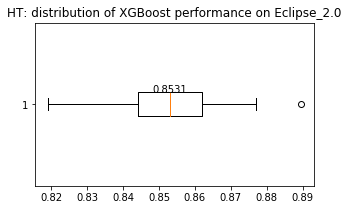

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

plt.rcParams["figure.figsize"] = (5, 3)
fig1, ax1 = plt.subplots()
ax1.set_title('HT: distribution of XGBoost performance on Eclipse_2.0')
bp_dict = ax1.boxplot(auc_weighted_list,vert=False)
for line in bp_dict['medians']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    text(x, y, round(x,4),
         horizontalalignment='center') # draw above, centered

In [ ]:
import pandas as pd
import json
children = list(hyperdrive_run.get_children())
metricslist = {}
for run in children:
    #properties = run.get_properties()
    #metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    if 'Hyper parameter' not in run.get_metrics().keys():
        continue
    d = run.get_metrics()['Hyper parameter']
    d['auc_weighted'] = run.get_metrics()['auc_weighted']
    metricslist[int(run.get_details() ['runId'].split('_')[-1])] = d

rundata = pd.DataFrame(metricslist).sort_index(1).transpose()
rundata



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
#import pandas.plotting.parallel_coordinates as parallel_coordinates
plt.figure()
plotdata = rundata
plotdata['auc_weighted_cut'] = pd.cut(plotdata['auc_weighted'], (np.linspace(start=80, stop=90, num=15)/100).tolist())
#plotdata['auc_weighted_cut'] = plotdata['auc_weighted']
pd.plotting.parallel_coordinates(
    plotdata[['auc_weighted_cut','colsample_bytree', 'learning_rate','max_depth', 'subsample']] 
    ,'auc_weighted_cut'
    , colormap='Blues' )
plt.yscale('log')
plt.show()

In [ ]:
def parallel_coordinates(frame, class_column, cols=None, ax=None, color=None,
                     use_columns=False, xticks=None, colormap=None,
                     **kwds):
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    n = len(frame)
    class_col = frame[class_column]
    class_min = np.amin(class_col)
    class_max = np.amax(class_col)

    if cols is None:
        df = frame.drop(class_column, axis=1)
    else:
        df = frame[cols]

    used_legends = set([])

    ncols = len(df.columns)

    # determine values to use for xticks
    if use_columns is True:
        if not np.all(np.isreal(list(df.columns))):
            raise ValueError('Columns must be numeric to be used as xticks')
        x = df.columns
    elif xticks is not None:
        if not np.all(np.isreal(xticks)):
            raise ValueError('xticks specified must be numeric')
        elif len(xticks) != ncols:
            raise ValueError('Length of xticks must match number of columns')
        x = xticks
    else:
        x = range(ncols)

    fig = plt.figure()
    ax = plt.gca()

    Colorm = plt.get_cmap(colormap)

    for i in range(n):
        y = df.iloc[i].values
        kls = class_col.iat[i]
        ax.plot(x, y, color=Colorm((kls - class_min)/(class_max-class_min)), **kwds)

    for i in x:
        ax.axvline(i, linewidth=1, color='black')

    ax.set_xticks(x)
    ax.set_xticklabels(df.columns)
    ax.set_xlim(x[0], x[-1])
    ax.legend(loc='upper right')
    ax.grid()

    bounds = np.linspace(class_min,class_max,10)
    cax,_ = mpl.colorbar.make_axes(ax)
    cb = mpl.colorbar.ColorbarBase(cax, cmap=Colorm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%.2f')

    return fig

In [ ]:
parallel_coordinates(rundata, 'auc_weighted')